In [76]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [79]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [80]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())


Number of Examples :  15830 

Number of Examples after removing duplicates:  15727 

Number of words before cleaning :  498871
Number of words after cleaning :  327648

******************

Negative Examples :  3905
Positive Examples :  11822


In [81]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

0        homz low fee among homebuild etf previous sunk...
1        top rank momentum stock buy august top rank mo...
2        strategi gpx earn top estim strategi gpx deliv...
3        pfizer help manufactur gilead remdesivir share...
4        dish network dish surpass earn revenu estim di...
                               ...                        
15722    dividend aristocrat abbvi declar latest payout...
15723    tesla bull dan ive talk batteri day competit r...
15724    tesla valu car compani gerber gerber kawasaki ...
15725    peloton post first ever profit covid boost yah...
15726    wingstop unparallel growth wingstop came stron...
Name: Article, Length: 15727, dtype: object


In [82]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler(sampling_strategy=0.95)
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Negative Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train['Target']==1).sum())

train.to_csv (r'General1.csv', index = False, header=True)
test.to_csv (r'General2.csv', index = False, header=True)
val.to_csv (r'General3.csv', index = False, header=True)

Negative Examples in Training after OverSampling:  6289
Positive Examples in Training after OverSampling:  6620


In [83]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General1.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'General2.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'General3.csv',format = 'csv',fields = fields,skip_header = True)


TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 10631
Size of LABEL vocabulary: 2
[('stock', 8115), ('earn', 5208), ('report', 3769), ('compani', 2360), ('share', 1860), ('day', 1779), ('market', 1585), ('quarter', 1510), ('revenu', 1483), ('buy', 1431)]


In [84]:
def find_accuracy(preds, y):
   
    temp = torch.round(preds)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y

def Loss_Optimizer (model,valueLR):
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [85]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(1)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [86]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [87]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    

In [88]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')

In [89]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [90]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [91]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [92]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(10631, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(10631, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch :  5  Train Loss :  0.29745246240725887   Train Acc :  0.8777194481629592   Valid Loss :  0.3937346637248993  Val Acc :  0.8557985027631124
Epoch :  10  Train Loss :  0.1214815630362584   Train Acc :  0.9533335474821237   Valid Loss :  0.4254992703596751  Val Acc :  0.8862664103507996
Epoch :  15  Train Loss :  0.07336973226987399   Train Acc :  0.9724428653717041   Valid Loss :  0.4769895672798157  Val Acc :  0.8958037495613098
Epoch :  20  Train Loss :  0.046896715863392904   Train Acc :  0.9834551719518808   Valid Loss :  0.6485251983006796  Val Acc :  0.8953640659650167
Epoch :  25  Train Loss :  0.04488575608971027   Train Acc :  0.9832521906265845   Valid Loss :  0.5729363560676575  Val Acc :  0.9020858605702718
Epoch :  30  Train Loss :  0.02780311669294651   Train Acc :  0.9897349064166729   Valid Loss :  0.7373997370402018  Val Acc :  0.8938506245613098
Epoch :  35  Train Loss :  0.01418654196179257   Train Acc :  0.9957932692307693   Valid Loss :  0.9415259957313538  Va

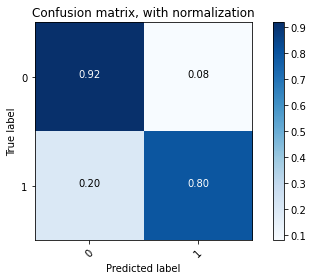

In [93]:
process_test(new_model2,40,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","LSTM_General_Negpositv_model.pt")

Epoch :  5  Train Loss :  0.3451462708986722   Train Acc :  0.8519891500473022   Valid Loss :  0.321857084830602  Val Acc :  0.8809439341227213
Epoch :  10  Train Loss :  0.2860272457966438   Train Acc :  0.8964611521134009   Valid Loss :  0.30932055910428363  Val Acc :  0.88494739929835
Epoch :  15  Train Loss :  0.083555118395732   Train Acc :  0.9680898877290579   Valid Loss :  0.4808809260527293  Val Acc :  0.8903840382893881
Epoch :  20  Train Loss :  0.055542268145542875   Train Acc :  0.9785987276297349   Valid Loss :  0.5038786927858988  Val Acc :  0.8999213576316833
Epoch :  25  Train Loss :  0.040286082201279126   Train Acc :  0.9855809165881231   Valid Loss :  0.5582763055960337  Val Acc :  0.8920116424560547
Epoch :  30  Train Loss :  0.03166206625218575   Train Acc :  0.9889349524791424   Valid Loss :  0.6301932334899902  Val Acc :  0.8973171909650167
Epoch :  35  Train Loss :  0.025782103220430706   Train Acc :  0.9903134887035077   Valid Loss :  0.6601510047912598  Val A

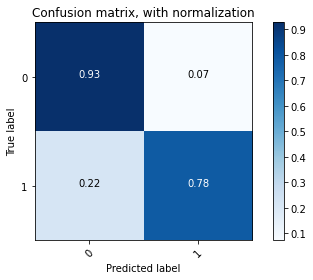

In [94]:
process_test(new_model3,40,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","GRU_General_Negpositv_model.pt")